# prompt engineering

In [1]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling, GPT2LMHeadModel, pipeline, \
                         GPT2Tokenizer
import pandas as pd
from datasets import Dataset

#### we're gonna use a data set called Amazon Fine Food Reviews, which are 50,000 food reviews from Amazon, and the way we're gonna use it is by taking the actual reviews from Amazon and generating two prompts

In [2]:
# https://www.kaggle.com/snap/amazon-fine-food-reviews?select=Reviews.csv

reviews = pd.read_csv('./data/reviews.csv')

print(reviews.shape)

reviews.head()

(96512, 3)


Text                 Summary  \
0  Great taffy at a great price.  There was a wid...             Great taffy   
1  This taffy is so good.  It is very soft and ch...  Wonderful, tasty taffy   
2  Right now I'm mostly just sprouting this so my...              Yay Barley   
3  This is a very healthy dog food. Good for thei...        Healthy Dog Food   
4  good flavor! these came securely packed... the...       fresh and greasy!   

   Score  
0      5  
1      5  
2      5  
3      5  
4      4

#### We are going to create a prompt for a sentiment analysis and a separate prompt for summarization

#### If we take a histogram of the length of strings of our text, we can see that we have a mildly left skewed data set here where we have an average, what seems to be around 120, 130 characters, but with a tail coming here at the left

<AxesSubplot:title={'center':'Histogram of Review Length'}, ylabel='Frequency'>

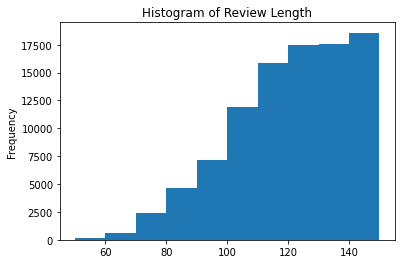

In [3]:
reviews['Text'].str.len().plot(kind='hist', title='Histogram of Review Length')

#### let's go ahead and nip this in the bud, only grabbing reviews whose summary length is between 10 and 25 characters

<AxesSubplot:title={'center':'Histogram of Summary Length'}, ylabel='Frequency'>

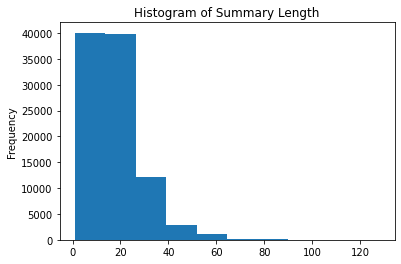

In [4]:
reviews['Summary'].str.len().plot(kind='hist', title='Histogram of Summary Length')

#### remove very short and very long summaries

<AxesSubplot:title={'center':'Histogram of Summary Length'}, ylabel='Frequency'>

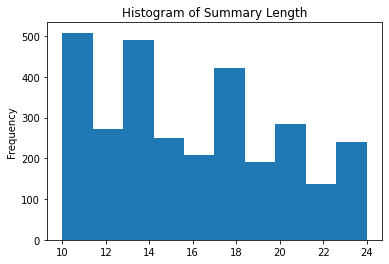

In [9]:
reviews = reviews[(reviews['Summary'].str.len() >= 10) & (reviews['Summary'].str.len() < 25)]

reviews['Summary'].str.len().plot(kind='hist', title='Histogram of Summary Length')

####  mapping our score to be a sentiment column where it'll be positive if the score was four or five, neutral, if it was three, and then negative if it were one or two, and to make this a little bit more even

In [11]:
reviews['Sentiment'] = reviews['Score'].map(lambda x: 'positive' if x >= 4 else 'neutral' if x == 3 else 'negative')

# Take 1,000 examples from each sentiment group
reviews = reviews.groupby('Sentiment', group_keys=False).apply(lambda x: x.sample(1000))

####  we have evenly distributed data points across negative, positive, and neutral, 3,000 data points in our reviews set

<AxesSubplot:>

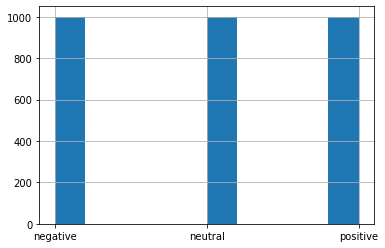

In [12]:
reviews['Sentiment'].hist()

#### we'll be using a distill diversion of GPT-2. This is like DistilBERT, but it's just distilgpt2

In [13]:
MODEL = 'distilgpt2'

tokenizer = GPT2Tokenizer.from_pretrained(MODEL)

tokenizer.pad_token = tokenizer.eos_token

#add two prompts, one for each task
SENTIMENT_PROMPT = 'Sentiment Task'
SUMMARIZE_PROMPT = 'Summarize Task'
SENTIMENT_TOKEN = '\nSentiment:'
SUMMARIZE_TOKEN = '\nSummarize:'

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

#### we're gonna create two prompts, a sentiment task, a summarized task, and then our tokens at the end which will tell GPT-2 when to start actually performing our task

In [14]:
reviews['sentiment_text'] = f'{SENTIMENT_PROMPT}\nReview: ' + reviews['Text'] + SENTIMENT_TOKEN +  ' ' + reviews['Sentiment'].astype(str)

reviews['summarize_text'] = f'{SUMMARIZE_PROMPT}\nReview: ' + reviews['Text'] + SUMMARIZE_TOKEN +  ' ' + reviews['Summary'].astype(str)

#### here's a sentiment prompt that we have for training

In [15]:
reviews['sentiment_text'].head(2).tolist()

['Sentiment Task\nReview: I ordered 4boxes for presents. one tea bag which is lemon tea was empty. Little bit disappointed.\nSentiment: negative',
 'Sentiment Task\nReview: All cookies arrived brocken. Such expensive cookies and so poor pack! I believe the manufacturer should improve the way that they pack.\nSentiment: negative']

In [16]:
print('Sentiment Task\nReview: I just made this for lunch. It had almost no flavor, although it smelled heavenly for the first few minutes of cooking.\nSentiment: negative')

Sentiment Task
Review: I just made this for lunch. It had almost no flavor, although it smelled heavenly for the first few minutes of cooking.
Sentiment: negative


#### and similarly, we will take our first summary

In [17]:
reviews['summarize_text'].head(2).tolist()

['Summarize Task\nReview: I ordered 4boxes for presents. one tea bag which is lemon tea was empty. Little bit disappointed.\nSummarize: Empty tea bag',
 'Summarize Task\nReview: All cookies arrived brocken. Such expensive cookies and so poor pack! I believe the manufacturer should improve the way that they pack.\nSummarize: Bad packing!']

In [18]:
print('Summarize Task\nReview: I just made this for lunch. It had almost no flavor, although it smelled heavenly for the first few minutes of cooking.\nSummarize: Not bad, but bland')

Summarize Task
Review: I just made this for lunch. It had almost no flavor, although it smelled heavenly for the first few minutes of cooking.
Summarize: Not bad, but bland


#### this line will shuffle up our data set ...

In [20]:
reviews = reviews.sample(frac=1)

#### ... and then we are going to take our training examples from our lists.

In [21]:
training_examples = reviews['summarize_text'].tolist() + reviews['sentiment_text'].tolist()

# 6,000 = 2 prompts per 1,000 examples from the 3 sentiment groups
print(len(training_examples))

6000


#### We'll create a data frame where the only column is text, and it will contain all 6,000 of our training examples and then extract a dataset from it

In [22]:
multi_task_df = pd.DataFrame({'text': training_examples})

data = Dataset.from_pandas(multi_task_df)

def preprocess(examples):
    return tokenizer(examples['text'], truncation=True)

data = data.map(preprocess, batched=True)

data = data.train_test_split(train_size=.8)

  0%|          | 0/6 [00:00<?, ?ba/s]

#### we have our distilgpt2 model loaded up here

In [23]:
model = GPT2LMHeadModel.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/336M [00:00<?, ?B/s]

#### we have our collator DataCollatorForLanguageModeling with our tokenizer

In [24]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

#### So we'll start with our training arguments

In [25]:
training_args = TrainingArguments(
    output_dir="./gpt2_multitask", #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=2, # number of training epochs
    per_device_train_batch_size=32, # batch size for training
    per_device_eval_batch_size=32,  # batch size for evaluation
    logging_steps=50,
    load_best_model_at_end=True,
    evaluation_strategy='epoch',
    save_strategy='epoch'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data['train'],
    eval_dataset=data['test'],
    data_collator=data_collator
)

trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text. If text are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1200
  Batch size = 32


{'eval_loss': 4.999570369720459,
 'eval_runtime': 71.392,
 'eval_samples_per_second': 16.809,
 'eval_steps_per_second': 0.532}

In [26]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text. If text are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
/home/caf/my_project_dir/my_project_env/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4800
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 300


The following columns in the evaluation set  don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text. If text are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1200
  Batch size = 32
Saving model checkpoint to ./gpt2_multitask/checkpoint-150
Configuration saved in ./gpt2_multitask/checkpoint-150/config.json
Model weights saved in ./gpt2_multitask/checkpoint-150/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text. If text are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1200
  Batch size = 32
Saving model checkpoint to ./gpt2_multitask/checkpoint-300
Configuration saved in ./gpt2_multitask/checkpoint-300/config.json
Model weights saved in ./gpt2_multitask/checkpoint-300/pytorch_model.bi

TrainOutput(global_step=300, training_loss=2.898728485107422, metrics={'train_runtime': 1785.9927, 'train_samples_per_second': 5.375, 'train_steps_per_second': 0.168, 'total_flos': 138021842976768.0, 'train_loss': 2.898728485107422, 'epoch': 2.0})

In [27]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text. If text are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1200
  Batch size = 32


{'eval_loss': 2.6978344917297363,
 'eval_runtime': 57.9964,
 'eval_samples_per_second': 20.691,
 'eval_steps_per_second': 0.655,
 'epoch': 2.0}

#### we can save it to the corresponding directory, gpt2_multitask

In [28]:
trainer.save_model()

Saving model checkpoint to ./gpt2_multitask
Configuration saved in ./gpt2_multitask/config.json
Model weights saved in ./gpt2_multitask/pytorch_model.bin


#### we can then load up our model from our checkpoint and create a pipeline for text generation

In [29]:
loaded_model = GPT2LMHeadModel.from_pretrained('./gpt2_multitask')

generator = pipeline('text-generation', model=loaded_model, tokenizer=tokenizer)

loading configuration file ./gpt2_multitask/config.json
Model config GPT2Config {
  "_name_or_path": "distilgpt2",
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "torch_dtype": "f

#### We're gonna go ahead and grab a sample review from our data set, grab the ground truth text sentiment and summary

In [30]:
text_sample, score, summary = reviews.sample(1)[['Text', 'Sentiment', 'Summary']].values[0]

print(text_sample)
print(score)
print(summary)

num_tokens = len(tokenizer(text_sample)['input_ids'])
num_tokens

The price was good and delivery was fast on this order, but every bar in the package was broken.
neutral
Bars broken


21

In [31]:
sentiment_text_sample = f'{SENTIMENT_PROMPT}\nReview: {text_sample}{SENTIMENT_TOKEN}'
summarize_text_sample = f'{SUMMARIZE_PROMPT}\nReview: {text_sample}{SUMMARIZE_TOKEN}'

In [32]:
print(sentiment_text_sample)

Sentiment Task
Review: The price was good and delivery was fast on this order, but every bar in the package was broken.
Sentiment:


In [33]:
print(summarize_text_sample)

Summarize Task
Review: The price was good and delivery was fast on this order, but every bar in the package was broken.
Summarize:


In [34]:
for generated_text in generator(sentiment_text_sample, num_return_sequences=1, max_length=num_tokens + 1):
    print(generated_text['generated_text'])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 31, but ``max_length`` is set to 22. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.


Sentiment Task
Review: The price was good and delivery was fast on this order, but every bar in the package was broken.
Sentiment: neutral


In [35]:
for generated_text in generator(summarize_text_sample, num_return_sequences=3, max_length=num_tokens + 20):
    print(generated_text['generated_text'])
    print('----')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Summarize Task
Review: The price was good and delivery was fast on this order, but every bar in the package was broken.
Summarize: The product was fine, and the shipping
----
Summarize Task
Review: The price was good and delivery was fast on this order, but every bar in the package was broken.
Summarize: bad service with product arrived promptly.

----
Summarize Task
Review: The price was good and delivery was fast on this order, but every bar in the package was broken.
Summarize: broken bar! The prices were great.
----


####  if we had taken a base GPT-2 model with this prompt, it should not perform as well... (these are definitely not as good as our fine-tuned)

In [36]:
generator = pipeline('text-generation', model=GPT2LMHeadModel.from_pretrained('gpt2'), tokenizer=tokenizer)

loading configuration file https://huggingface.co/gpt2/resolve/main/config.json from cache at /home/caf/.cache/huggingface/transformers/fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01.7d2e0efa5ca20cef4fb199382111e9d3ad96fd77b849e1d4bed13a66e1336f51
Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": 

In [37]:
for generated_text in generator(sentiment_text_sample, num_return_sequences=5, max_length=num_tokens + 1):
    print(generated_text['generated_text'])
    print('-------')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 31, but ``max_length`` is set to 22. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.


Sentiment Task
Review: The price was good and delivery was fast on this order, but every bar in the package was broken.
Sentiment: The
-------
Sentiment Task
Review: The price was good and delivery was fast on this order, but every bar in the package was broken.
Sentiment: All
-------
Sentiment Task
Review: The price was good and delivery was fast on this order, but every bar in the package was broken.
Sentiment: The
-------
Sentiment Task
Review: The price was good and delivery was fast on this order, but every bar in the package was broken.
Sentiment: 5
-------
Sentiment Task
Review: The price was good and delivery was fast on this order, but every bar in the package was broken.
Sentiment: I
-------


In [38]:
for generated_text in generator(summarize_text_sample, num_return_sequences=3, max_length=num_tokens + 20):
    print(generated_text['generated_text'])
    print('----')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Summarize Task
Review: The price was good and delivery was fast on this order, but every bar in the package was broken.
Summarize: The bar was broken but we will have
----
Summarize Task
Review: The price was good and delivery was fast on this order, but every bar in the package was broken.
Summarize: The price was good and deliver was fast
----
Summarize Task
Review: The price was good and delivery was fast on this order, but every bar in the package was broken.
Summarize: Excellent products, excellent service.
Review
----
